# An Analysis of News Head Lines Part 2
# Descriptive Analytics & Sentiment Analysis
### Noah Minshew

"On my honor, as a student, I have neither given nor received unauthorized aid on this academic work."

---

## Import Packages

In [1]:
#news api
from newsapi import NewsApiClient

#CSV
import csv
from collections import Counter

#pandas
import pandas as pd

#Matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
% matplotlib inline

#numpy
import numpy as np

# nltk
import nltk
# stopwords, FreqDist, word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

#regular expression
import re

#seaborn
import seaborn as sns

#pip install scikit-plot 
import scikitplot as skplt

## Data Preprocessing

In [2]:
# Read the data collected in the first notebook
df = pd.read_csv("data/allheadlines.csv")
df.head(2)

,Unnamed: 0,description,source,url,title,date
0,0,Liberal activist and filmmaker Michael Moore j...,breitbart-news,http://www.breitbart.com/big-hollywood/2018/03...,Michael Moore Hammers Media for Obsessive Cove...,2018-03-20T10:22:37Z
1,1,Cartel violence in Tijuana continues with no e...,breitbart-news,http://www.breitbart.com/texas/2018/04/21/11-k...,TIJUANA: 11 Killed in 24 Hours...,2018-04-21T17:04:39Z


In [3]:
#remove the unnamed column, we do not need it. 
del df['Unnamed: 0']

In [4]:
df.groupby(['source']).count()

,description,url,title,date
source,,,,
breitbart-news,7341,7341,7341,7341
cnn,9678,9900,9900,9900
fox-news,9900,9900,9900,9900
msnbc,5873,5873,5873,5873
national-review,3218,3218,3218,3218
the-american-conservative,835,835,835,835
the-huffington-post,7150,7150,7148,7150
the-new-york-times,9897,9900,9900,9900
the-washington-post,9886,9900,9900,9900


In [5]:
#create column for bias (conservative or liberal) 
#true will be conservative, false will be liberal
df['bias'] = df.source.str.contains("breitbart-news|fox-news|national-review|the-american-conservative|the-washington-times")

In [6]:
#converrt the boolean type to string
df['bias'] = df['bias'].astype(str)

In [7]:
#true = conservative
#false = liberal
df['bias'] = df['bias'].str.replace('True', 'Conservative')
df['bias'] = df['bias'].str.replace('False', 'Liberal')
df.head(1)

,description,source,url,title,date,bias
0,Liberal activist and filmmaker Michael Moore j...,breitbart-news,http://www.breitbart.com/big-hollywood/2018/03...,Michael Moore Hammers Media for Obsessive Cove...,2018-03-20T10:22:37Z,Conservative


In [8]:
#lets create a dataframe with just the information we will need for exploratory data analysis
data = df[['title', 'bias', 'source']]

In [9]:
data['title'] = data['title'].astype(str)

C:\Users\nminshew\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
#we need to drop the titles that begin with MPT 
# (MTP Daily--April 13, 2018) these dont give us any meaning
data = data[~data['title'].astype(str).str.startswith('MTP')]

In [11]:
#we need to also drop duplicates
data = data.drop_duplicates(['title'], keep = 'last')

In [12]:
#create seperate dataframes
df_conservative = data[data.bias=="Conservative"].copy()
df_liberal = data[data.bias=="Liberal"].copy()

In [13]:
#now we can drop the bias column from each
df_conservative = df_conservative.drop('bias', axis=1)
df_liberal = df_liberal.drop('bias', axis=1)

In [14]:
#Convert values to lists
conservative = df_conservative.values.tolist()
liberal = df_liberal.values.tolist()

Tokenization and Data Preprocessing
>Convert to string, make all characters lowercase, get rid of non alpha-numeric characters, tokenize words, remove stopwords, remove short words, create frequency distribution using nltk.

In [15]:
#list for extra stopwords
more_stopwords = set(('will', 'people', 'need', 'think', 'well','going', 'can', 'know', 'lot', 'get','make','way', 'want',
                      'like','say','got','said','just','something','tell','put','now','back','want','right','every','one',
                      'use','come','never', 'many','along','things','day','also','first','guy','take', 'good', 'much',
                      'let', 'would', 'thing', 'talk', 'talking', 'thank', 'does', 'give', 'look', 'tonight','today', 
                      'see', 'news', 'fox', 'new', 'may', 'could', 'show', 'time', 'breitbart', "fox", "fox news", 
                      "breitbart", "national review", "the american conservative", "american conservative", 
                      "the washington times", "washington times", "cnn", "the new york times", "new york times", 
                      "the washington post", "washington post", "the huffington post", "huffington post", "msnbc", 
                      "news", "contributor", "columnist", "post", "contributing", "daily", "january", "march", 
                      "april", "may", "june", "july", "august", "september", "october", "november", "december", 
                      "op ed", "writer", "opinion", "huffpost", "op", "ed", "say", "time", "new", "day", 
                       "get", "post", "washington", "make", "want", "york", "could", "news"))

In [16]:
#preprocessing for conservative data
tokens = str(conservative)
tokens = tokens.lower()
tokens = re.sub("[^a-zA-Z0-9]", " ", tokens)
tokens = word_tokenize(tokens)
wordnet_lemmatizer = WordNetLemmatizer()
tokens = (wordnet_lemmatizer.lemmatize(word) for word in tokens)
extra_stoplist = set(stopwords.words('english')) | more_stopwords
tokens = (word for word in tokens if word not in extra_stoplist)
tokens = (word for word in tokens if word.isalpha())
conservative_tokens = (word for word in tokens if len(word) >= 3)
fdist_conservative = nltk.FreqDist(conservative_tokens)

In [17]:
#append fdist to dataframe
freq_word_c = []
# two values or columns in fdist_a
for k,v in fdist_conservative.items():
    freq_word_c.append([k,v])
#make it like an Excel worksheet
wordlist_c = pd.DataFrame(freq_word_c)
wordlist_c = wordlist_c.rename(columns={0: 'word', 1: 'freq'})

In [18]:
#preprocessing for liberal data
tokens = str(liberal)
tokens = tokens.lower()
tokens = re.sub("[^a-zA-Z0-9]", " ", tokens)
tokens = word_tokenize(tokens)
wordnet_lemmatizer = WordNetLemmatizer()
tokens = (wordnet_lemmatizer.lemmatize(word) for word in tokens)
extra_stoplist = set(stopwords.words('english')) | more_stopwords
tokens = (word for word in tokens if word not in extra_stoplist)
tokens = (word for word in tokens if word.isalpha())
liberal_tokens = (word for word in tokens if len(word) >= 3)
fdist_liberal = nltk.FreqDist(liberal_tokens)

In [19]:
#append fdist to dataframe
freq_word_l = []
# two values or columns in fdist_a
for k,v in fdist_liberal.items():
    freq_word_l.append([k,v])
#make it like an Excel worksheet
wordlist_l = pd.DataFrame(freq_word_l)
wordlist_l = wordlist_l.rename(columns={0: 'word', 1: 'freq'})

In [20]:
#we want only the top thirty words
wordlist_c = wordlist_c.sort_values(by=['freq'], ascending=False).head(30)
wordlist_l = wordlist_l.sort_values(by=['freq'], ascending=False).head(30)

#### Lets Plot the Word Frequency using seaborn

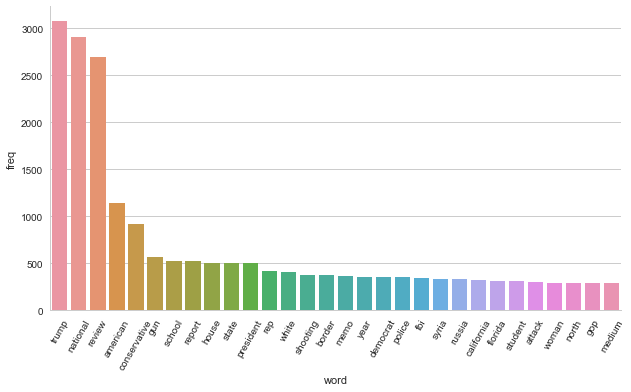

In [21]:
#Conservative Words
sns.set(style="whitegrid")
sns.color_palette(palette=None, n_colors=None, desat=None)
g = sns.factorplot(x="word", y="freq", data=wordlist_c,
                   size=5, kind="bar", aspect=1.8)
g.set_xticklabels(rotation=60)

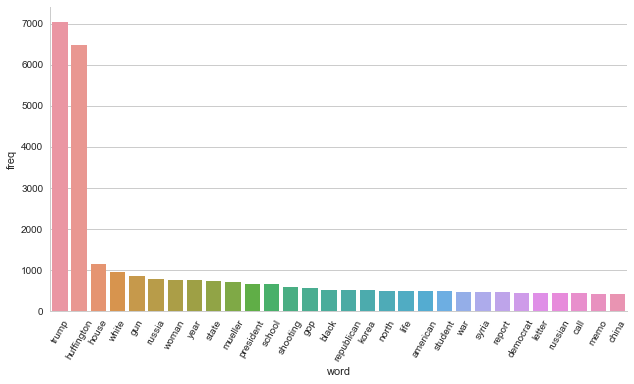

In [22]:
#Liberal Words
sns.set(style="whitegrid")
sns.color_palette(palette=None, n_colors=None, desat=None)
g = sns.factorplot(x="word", y="freq", data=wordlist_l,
                   size=5,kind="bar", aspect=1.8)
g.set_xticklabels(rotation=60)

##### The results here do not have any suprising findings, the most common words are very similar

## Lets add some additional metrics to our dataframe

In [23]:
data.head(2)

,title,bias,source
0,Michael Moore Hammers Media for Obsessive Cove...,Conservative,breitbart-news
1,TIJUANA: 11 Killed in 24 Hours...,Conservative,breitbart-news


In [24]:
#count words in each title
data['word_count']=data["title"].apply(lambda x: len(str(x).split()))
#count unique words in each title
data['unique_words']=data["title"].apply(lambda x: len(set(str(x).split())))

In [25]:
data.groupby('bias').mean()

,word_count,unique_words
bias,,
Conservative,10.238433,10.132074
Liberal,10.501313,10.362213


In [26]:
data.groupby('source').mean()

,word_count,unique_words
source,,
breitbart-news,12.023671,11.866569
cnn,9.021277,8.938169
fox-news,10.205777,10.119012
msnbc,8.532901,8.461949
national-review,7.019209,6.952542
the-american-conservative,6.427471,6.364570
the-huffington-post,10.925182,10.778482
the-new-york-times,10.016851,9.842546
the-washington-post,13.157663,12.969436


* The American Conservative has the lowest amount of words in each title
* The Washinton Post has the most words in each title

In [27]:
data.head()

,title,bias,source,word_count,unique_words
0,Michael Moore Hammers Media for Obsessive Cove...,Conservative,breitbart-news,10,10
1,TIJUANA: 11 Killed in 24 Hours...,Conservative,breitbart-news,6,6
2,Actor attacks in obscenity-filled rant...,Conservative,breitbart-news,5,5
3,Baseball Viewership Lowest in Decade...,Conservative,breitbart-news,5,5
4,California Trains Running Even Slower Due to H...,Conservative,breitbart-news,10,10


In [28]:
df = data[['title', 'bias', 'source']]

In [29]:
df.to_csv('data/cleanheadlines.csv')

# Sentiment Analysis
* #### Sentiment Analysis will be preformed using R. See the R Notebook for details
    * https://cdn.rawgit.com/nminshew5/MIS670FinalProject/e2a2c1d4/MIS670FinalProject_Seniment_RNotebook.html
* #### After preforming sentiment analysis with R we will visualize and explain the results here

In [30]:
df1 = pd.read_csv("data/headlineSentiment.csv")
df1.head(1)

,Unnamed: 0,title,bias,source,category_senti,sent.value,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
0,1,Michael Moore Hammers Media for Obsessive Cove...,Conservative,breitbart-news,Negative,-1.0,0,0,0,1,0,0,0,0,1,0


In [31]:
del df1['Unnamed: 0']

In [32]:
df1.groupby('category_senti').mean()

,sent.value,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
category_senti,,,,,,,,,,,
Negative,-0.790661,0.544104,0.271170,0.269772,0.723572,0.124425,0.417656,0.378277,0.416553,1.015443,0.439865
Neutral,0.000000,0.075763,0.173958,0.044304,0.122022,0.057148,0.068038,0.052308,0.261169,0.145942,0.241251
Positive,0.693587,0.158151,0.443184,0.087805,0.226855,0.429166,0.139872,0.326162,0.692323,0.291348,1.053915


#### Overall, news headlines tend to be more negative. This may be because negativity, fear, disgust, and anger grab peoples attention. 

In [33]:
df1.groupby('bias').mean()

,sent.value,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
bias,,,,,,,,,,,
Conservative,-0.237242,0.377071,0.306865,0.190661,0.519314,0.215085,0.278029,0.290026,0.516247,0.682268,0.625565
Liberal,-0.092360,0.300891,0.313459,0.153987,0.405764,0.215257,0.248429,0.304188,0.464150,0.571160,0.603997


In [34]:
df1.groupby('source').mean().sort_values(by=['sent.value'], ascending=False)

,sent.value,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
source,,,,,,,,,,,
the-new-york-times,0.035344,0.271761,0.334228,0.140067,0.361597,0.231727,0.255876,0.236235,0.431684,0.531502,0.627563
national-review,-0.091337,0.250471,0.242561,0.135593,0.331073,0.150282,0.210169,0.194727,0.370998,0.506215,0.532580
the-huffington-post,-0.119895,0.347040,0.339929,0.202350,0.441026,0.275158,0.299583,0.323234,0.488484,0.644458,0.652651
cnn,-0.120248,0.289174,0.271306,0.133655,0.412014,0.179147,0.222758,0.272011,0.428706,0.522981,0.532973
the-washington-post,-0.136892,0.323612,0.354176,0.169285,0.439733,0.222988,0.274537,0.332114,0.519910,0.638721,0.654864
msnbc,-0.161148,0.274461,0.240130,0.124928,0.370399,0.156971,0.167461,0.404158,0.450505,0.509632,0.527179
the-washington-times,-0.167260,0.317808,0.326027,0.224658,0.495890,0.213699,0.279452,0.345205,0.490411,0.693151,0.556164
fox-news,-0.216860,0.354947,0.303793,0.166222,0.503654,0.215172,0.262383,0.268878,0.516181,0.618374,0.594015
the-american-conservative,-0.242362,0.281130,0.209243,0.189987,0.417202,0.125802,0.216945,0.218228,0.287548,0.591784,0.405648


#### Findings: 
* The new york times is the only news source that has an overall mean positive sentiment value
* The national review is the most positive conservative news source

### Sentiment Spyder Chart
This will plot each sentiment category on a circle chart. This will make it easy to compare differences between biases, sources, and overall sentiment. 
Reference: https://python-graph-gallery.com/391-radar-chart-with-several-individuals/

In [35]:
#import packages
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

In [36]:
#the spyder chart will be based on the mean values of each sentiment category
df_mean = df1.groupby('bias').mean()
del df_mean['sent.value']

In [37]:
df = df_mean.reset_index()

### Spyder chart to compare conservative vs liberal

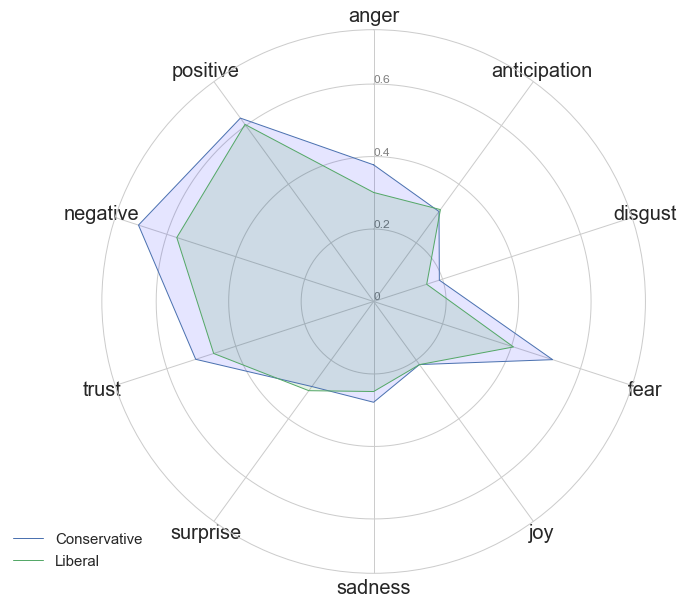

In [38]:
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111, polar=True)


# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, size=20)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0,0.2,0.4, 0.6], ["0","0.2","0.4", "0.6"], color="grey", size=12)
plt.ylim(0,.75)

 
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df.loc[0].drop('bias').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Conservative")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df.loc[1].drop('bias').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Liberal")
ax.fill(angles, values, 'g', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), prop={'size': 15}, markerscale=4)

### Findings: 
* This graph is interesting because it shows that conservative sources seem to have more emotion in generall than liberal news sources
* Liberal news headlines have a higher amount of suprise and anticipation than conservative news headlines
* Conservative news headlines are much more negative; they have more fear, sadness, disgust, and anger related words


### Spyder Chart for each news source: 

In [39]:
df_mean = df1.groupby('source').mean()
del df_mean['sent.value']

In [40]:
df = df_mean.reset_index()

In [41]:
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider( row, title, color):
    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(4,3,row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0,0.25,0.5, 0.75], ["0","0.25","0.5", "0.75"], color="grey", size=7)
    plt.ylim(0,1)

    # Ind1
    values=df.loc[row].drop('source').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)
    plt.tight_layout()

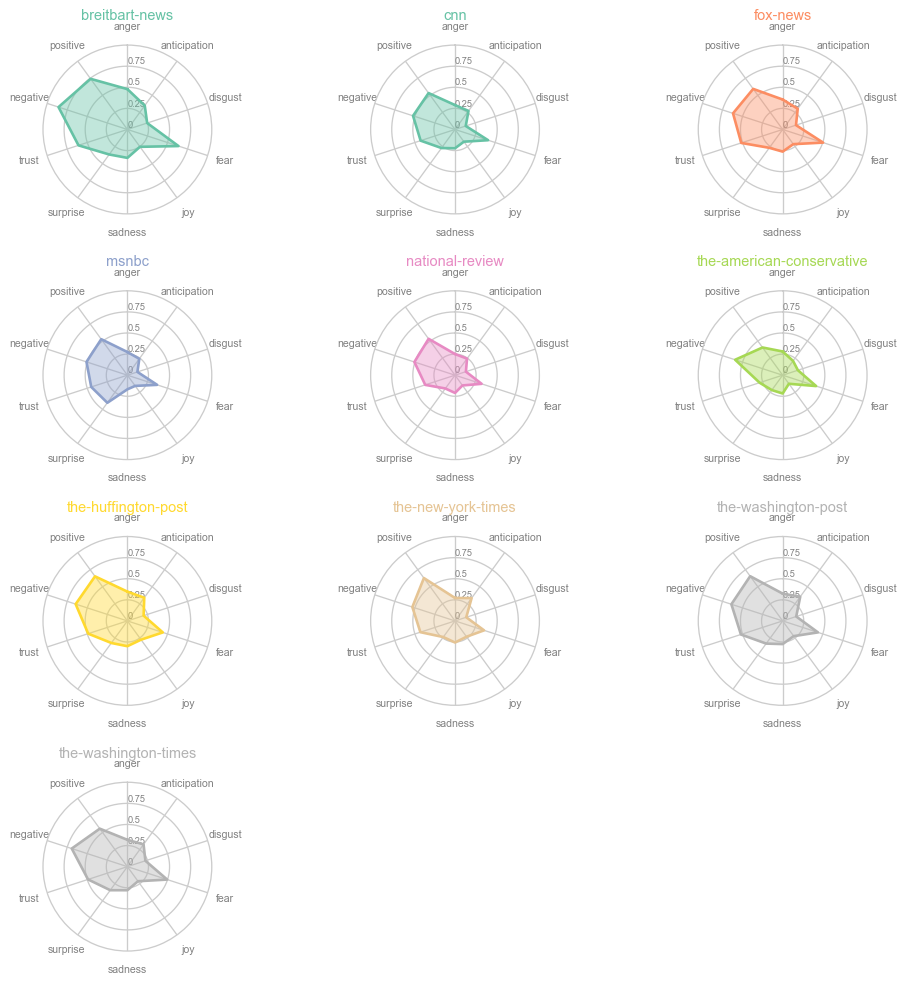

In [42]:
# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=95
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))
 
# Loop to plot
for row in range(0, len(df.index)):
    make_spider(row=row, title=df['source'][row], color=my_palette(row))

Findings:
* Breitbart news seems to be an outlier. They use they most emotion in thier headlines. Could this indicate they are attempting to click bait readers? 
* The American Conservative uses the least amount of emotion in thier headlines. 

### Spyder Chart to compare positive, negative and neutral articles

In [43]:
df_mean = df1.groupby('category_senti').mean()
del df_mean['sent.value']

In [44]:
df = df_mean.reset_index()

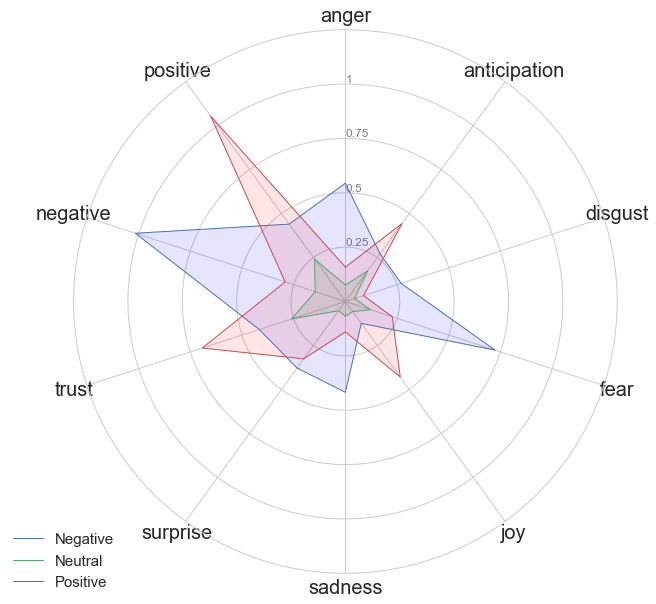

In [45]:
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111, polar=True)


# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, size=20)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.25,0.5,0.75, 1], ["0.25","0.5","0.75", "1"], color="grey", size=12)
plt.ylim(0,1.25)

 
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data

 
# Ind1
values=df.loc[0].drop('category_senti').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Negative")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df.loc[1].drop('category_senti').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Neutral")
ax.fill(angles, values, 'g', alpha=0.1)

# Ind3
values=df.loc[2].drop('category_senti').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Positive")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), prop={'size': 15}, markerscale=4)

### Findings:
* Positive articles invoke:  joy, anticipation, and trust
* Negative articles invoke: fear, anger, disgust, sadness, and suprise

## Word Freqencies of Positive and Negative Headlines

In [49]:
#Positive Headlines
df_p = df1[df1.category_senti=="Positive"].copy()
#Negative Headlines
df_n = df1[df1.category_senti=="Negative"].copy()

In [51]:
import scattertext as st
import spacy
from pprint import pprint
import en_core_web_sm

### Word topics of positve seniment for Liberal and Conservatives

In [57]:
empath_corpus = st.CorpusFromParsedDocuments(df_p, category_col='bias', 
                                             feats_from_spacy_doc=st.FeatsFromOnlyEmpath(), 
                                             parsed_col='title').build()

In [59]:
html = st.produce_scattertext_explorer(empath_corpus, category= 'Conservative', category_name='Conservative Headlines', 
                                       not_category_name='Liberal Headlines', width_in_pixels=1000, 
                                       metadata=df_p['source'], use_non_text_features=True, use_full_doc=True)
open("PostiveWord.html", 'wb').write(html.encode('utf-8'))

2822372

In [60]:
from IPython.display import IFrame
from IPython.core.display import display, HTML
file_name = 'PositiveWord.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=800)

Click here to view: https://cdn.rawgit.com/nminshew5/MIS670FinalProject/9280a9be/Visualizations/PostiveWord.html

### Word frequency of negative seniment for Liberal and Conservatives

In [61]:
empath_corpus = st.CorpusFromParsedDocuments(df_n, category_col='bias', 
                                             feats_from_spacy_doc=st.FeatsFromOnlyEmpath(), 
                                             parsed_col='title').build()

In [63]:
html = st.produce_scattertext_explorer(empath_corpus, category= 'Conservative', category_name='Conservative Headlines', 
                                       not_category_name='Liberal Headlines', width_in_pixels=1000, 
                                       metadata=df_n['source'], use_non_text_features=True, use_full_doc=True)
open("NegativeWord.html", 'wb').write(html.encode('utf-8'))

3959474

In [65]:
from IPython.display import IFrame
from IPython.core.display import display, HTML
file_name = 'NegativeWord.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=800)

Click here to view: https://cdn.rawgit.com/nminshew5/MIS670FinalProject/9280a9be/Visualizations/NegativeWord.html

## Export data for topic modeling

In [259]:
df3 = df1[['title', 'bias', 'source', 'category_senti']]
df3.head()

,title,bias,source,category_senti
0,Michael Moore Hammers Media for Obsessive Cove...,Conservative,breitbart-news,Negative
1,TIJUANA: 11 Killed in 24 Hours...,Conservative,breitbart-news,Negative
2,Actor attacks in obscenity-filled rant...,Conservative,breitbart-news,Negative
3,Baseball Viewership Lowest in Decade...,Conservative,breitbart-news,Negative
4,California Trains Running Even Slower Due to H...,Conservative,breitbart-news,Negative


In [260]:
df3.to_csv('data/headlineSent.csv')